# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

C:\Users\julia\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Read Dataset

In [2]:
test_df = pd.read_csv('./data/test_lAUu6dG.csv')

In [3]:
train_df = pd.read_csv('./data/train_ctrUa4K.csv')

# Dataset Overview

In [4]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

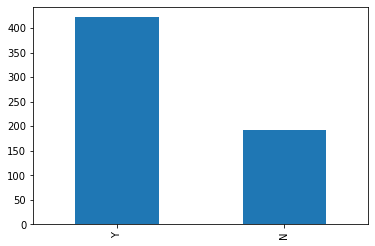

In [6]:
target = train_df['Loan_Status']
target.value_counts().plot(kind='bar')

I'm choosing to drop 'Gender', 'Married' and 'Property_Area' columns, because I don't want to use them as a parameter to approve or disaproove a loan

In [7]:
train_df = train_df.drop(columns=['Gender', 'Married', 'Property_Area', 'Loan_ID'])

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         599 non-null    object 
 1   Education          614 non-null    object 
 2   Self_Employed      582 non-null    object 
 3   ApplicantIncome    614 non-null    int64  
 4   CoapplicantIncome  614 non-null    float64
 5   LoanAmount         592 non-null    float64
 6   Loan_Amount_Term   600 non-null    float64
 7   Credit_History     564 non-null    float64
 8   Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 43.3+ KB


Categorical data

In [9]:
train_df.select_dtypes('object')

,Dependents,Education,Self_Employed,Loan_Status
0,0,Graduate,No,Y
1,1,Graduate,No,N
2,0,Graduate,Yes,Y
3,0,Not Graduate,No,Y
4,0,Graduate,No,Y
...,...,...,...,...
609,0,Graduate,No,Y
610,3+,Graduate,No,Y
611,1,Graduate,No,Y
612,2,Graduate,No,Y


Numerical data

In [10]:
train_df.select_dtypes(exclude='object')

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0
...,...,...,...,...,...
609,2900,0.0,71.0,360.0,1.0
610,4106,0.0,40.0,180.0,1.0
611,8072,240.0,253.0,360.0,1.0
612,7583,0.0,187.0,360.0,1.0


Missing values

In [11]:
train_df.isna().sum()

Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Loan_Status           0
dtype: int64

# Split train X test

In [12]:
X = train_df.drop(columns=['Loan_Status'])
y = train_df['Loan_Status']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Pipeline

## Preprocessing

### Categorical columns

In [14]:
cat_columns = list(X_train.select_dtypes('object').columns)

Use OrdinalEncoder to transform the data into ordered numbers  
Use OneHotEncoder to transform categorical data into binary numerical data (0, 1)  
Input missing values using KNNImputer

In [15]:
onehot_encoder = OneHotEncoder()

In [16]:
cat_imputer = SimpleImputer(strategy='most_frequent')

### Numerical columns

In [17]:
num_columns = list(X_train.select_dtypes(exclude='object').columns)

Imput missing values using SimpleImputer  
Standardize values

In [18]:
num_imputer = KNNImputer(n_neighbors=3)

In [19]:
scaler = StandardScaler()

## Pipeline for numerical and categorical data

For categorical:

In [20]:
cat_pipeline = Pipeline(steps=[('missing', cat_imputer),
                       ('encode', onehot_encoder)])

For numerical:

In [21]:
num_pipeline = Pipeline(steps=[('missing', num_imputer),
                       ('scaler', scaler)])

### Transform columns

In [22]:
cat_columns

['Dependents', 'Education', 'Self_Employed']

In [23]:
dataprep = ColumnTransformer(transformers=[('num_transform', num_pipeline, num_columns),
                                           ('cat_transform', cat_pipeline, cat_columns)])

## Pipeline for model (logistic regression)

In [24]:
model = LogisticRegression(n_jobs=-1)

In [25]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=3,
                                                              

Cross Validation

In [27]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.7377715045902563, 0.0776686312066127)

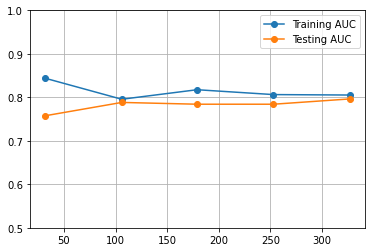

In [28]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

## Pipeline for model (Decision Tree)

In [29]:
model = DecisionTreeClassifier(max_depth=3)

In [30]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=3,
                                                              

Cross Validation

In [32]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.700238509350768, 0.0922395294371911)

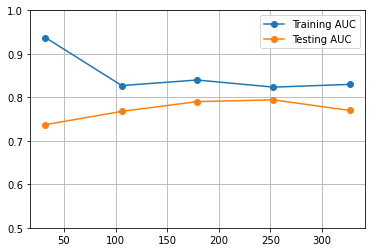

In [33]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

## Pipeline for model (LGBM)

In [34]:
model = LGBMClassifier(max_depth=2, n_estimators=70)

In [35]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=3,
                                                              

Cross Validation

In [37]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.7775564779483467, 0.05710013035934336)

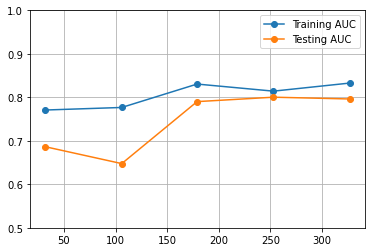

In [38]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

I decided to use LGBM for final model

# Saving models with PICKLE

In [39]:
joblib.dump(pipeline, 'model-lgbm.pkl')

['model-lgbm.pkl']

In [41]:
pipeline.named_steps['preprocessing'].named_transformers_['cat_transform'].named_steps['encode'].get_feature_names(input_features=cat_columns)

array(['Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Graduate', 'Education_Not Graduate', 'Self_Employed_No',
       'Self_Employed_Yes'], dtype=object)

In [44]:
train_df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64